<a href="https://colab.research.google.com/github/jihun0423/NLP/blob/main/language_translation_Keras_teacherForcing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

seq2seq language translation

### Encoder-Decoder model


- 영어-한국어 번역

In [ ]:
!pip install --upgrade --no-cache-dir gdown

한글 Glove file download

In [ ]:
!gdown 1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC

Downloading...
From: https://drive.google.com/uc?id=1zR1TJm9hjqinSU0OkCcAmaVjfeTgmoOC
To: /content/glove.6B.100d.txt
100% 347M/347M [00:01<00:00, 174MB/s]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Embedding, Input, LSTM, Bidirectional

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import plot_model

In [ ]:
BATCH_SIZE = 64
MAX_VOCAB_SIZE = 10000
EMBEDDING_DIM = 100
LATENT_DIM = 512

## 입력 data list 작성  

### 1. input_texts     : original language 의 input text  


### 2. Teacher Forcing 용 input / target data 생성

- target_texts_inputs  : 1 만큼 offset 된 target language sentence $\rightarrow$ `<sos>....`  
- target_texts  : target language sentence  $\rightarrow$ `.....<eos>`



- data 는 http://www.manythings.org/anki/  (Tab-delimited Bilingual Sentence Pairs) 에서 download  


    - English(input) + `\t` + The Other Language(target) + `\t` + Attribution(기여자) 형식으로 구성
        ex)
        - Hi.	안녕.	CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #8355888 (Eunhee).
        - I like horses.	나는 말을 좋아해.	CC-BY 2.0 (France) Attribution: tatoeba.org #1331062 (Kirschen112) & #8365125 (Eunhee)
        - We had fun with Tom.	우리는 톰과 즐거운 시간을 가졌다.	CC-BY 2.0 (France) Attribution: tatoeba.org #6845055 (CK) & #6845295 (dalgarak)

        
   

In [ ]:
file_path = tf.keras.utils.get_file("kor.txt",
             "https://github.com/ironmanciti/NLP_lecture/raw/master/data/kor.txt")

- teacher forcing 용 input, target 작성

In [ ]:
# load in the data
eng_texts = []
kor_inputs = []
kor_targets = []

# load data
for line in open(file_path, 'r', encoding='utf-8'):

    if '\t' not in line:     # \t 가 없는 line 은 skip
        continue

    # input 과 target translation 구분

    eng_texts.append(line.split('\t')[0])
    kor = line.split('\t')[1]
    kor_inputs.append('<sos> '+kor)
    kor_targets.append(kor+' <eos>')


    # target input 과 output 을 teacher forcing 입력 구성

print(len(eng_texts))
print(len(kor_inputs))
print(len(kor_targets))


(3318, 3318, 3318)

In [ ]:
print("English :", eng_texts[1100:1110])
print("\nTeacher Forcing Input :", kor_inputs[1100:1110])
print("\nTeacher Forcing Target", kor_targets[1100:1110])

English : ["Don't lie anymore, OK?", "Don't you laugh at me.", 'French is fascinating.', 'French is interesting.', 'French is very useful.', 'He looked quite tired.', 'He was about to speak.', 'He was born in Africa.', 'I called Tom for help.', "I didn't come by taxi."]

Teacher Forcing Input : ['<sos> 거짓말 하지 마세요, 알았죠?', '<sos> 날 비웃지마.', '<sos> 프랑스어는 매력적이야.', '<sos> 프랑스어는 흥미로워.', '<sos> 프랑스어는 아주 유용해.', '<sos> 그사람은 좀 지쳐보였어.', '<sos> 그사람이 말하려고 했어.', '<sos> 그는 아프리카에서 태어났다.', '<sos> 나는 톰에게 도움을 요청했다.', '<sos> 택시로 안 왔어.']

Teacher Forcing Target ['거짓말 하지 마세요, 알았죠? <eos>', '날 비웃지마. <eos>', '프랑스어는 매력적이야. <eos>', '프랑스어는 흥미로워. <eos>', '프랑스어는 아주 유용해. <eos>', '그사람은 좀 지쳐보였어. <eos>', '그사람이 말하려고 했어. <eos>', '그는 아프리카에서 태어났다. <eos>', '나는 톰에게 도움을 요청했다. <eos>', '택시로 안 왔어. <eos>']


## Tokenization

- language 가 2 개 이므로 언어별로 서로 다른 tokenizer 생성. 따라서, 2 개의 word_index 구성

### 영어 input text 의 tokenizer

In [ ]:
tokenizer_eng = Tokenizer()
tokenizer_eng.fit_on_texts(eng_texts)

eng_sequences = tokenizer_eng.texts_to_sequences(eng_texts)
eng_sequences[1000],eng_texts[1000]

[126, 12, 6, 94, 153]
Yesterday was a good day.


['yesterday', 'was', 'a', 'good', 'day']

In [ ]:
word2idx_eng = tokenizer_eng.word_index
print(f'unique input token 수 : {len(word2idx_eng)}')

num_words_eng = min(MAX_VOCAB_SIZE, len(word2idx_eng) + 1)
print("Input Text 의 단어 수 :", num_words_eng)

max_len_eng = max(len(s) for s in eng_sequences)
print("Input Text 의 최대 길이 :", max_len_eng)

unique input token 수 : 2395
Input Text 의 단어 수 : 2396
Input Text 의 최대 길이 : 101


### 한국어 Input Text

### Translation language 의 tokenizer
- 주의 사항 : $<sos>, <eos>$때문에 special character 를 filtering 하면 안됨

In [ ]:
tokenizer_kor = Tokenizer(filter = '')
tokenizer_kor.fit_on_texts(kor_inputs+kor_targets)

kor_input_sequences = tokenizer_kor.texts_to_sequences(kor_inputs)
kor_target_sequences = tokenizer_kor.texts_to_sequences(kor_targets)

kor_input_sequences[1000],kor_target_sequences[1000],kor_inputs[1000],kor_targets[1000]

[1, 1164, 87, 2706]
[1164, 87, 2706, 2]
['<sos>', '어제는', '좋은', '날이었다.']
['어제는', '좋은', '날이었다.', '<eos>']


In [ ]:
word2idx_kor = tokenizer_kor.word_index
print(f'unique output tokens : {len(word2idx_kor)}')

num_words_kor = len(word2idx_kor) +1
print("Target 언어의 단어 수 :", num_words_kor)

max_len_kor = max(len(s) for s in  kor_target_sequences)
print("Target 언어의 최대 길이 :", max_len_kor )

unique output tokens : 5324
Target 언어의 단어 수 : 5325
Target 언어의 최대 길이 : 90


## sequence padding


### 주의 사항
- encoder 는 thought vector 생성 목적이므로 `pre`(default) 로 padding


- decoder 는 teacher forcing 을 해야하므로 `post` 로 padding

In [ ]:
encoder_inputs = pad_sequences(eng_sequences,padding='pre',maxlen=maxlen_eng)
print(encoder_inputs.shape)
print(encoder_inputs[0])

decoder_inputs = pad_sequences(kor_input_sequences,padding='post',maxlen = maxlen_kor)
print('\n',decoder_inputs.shape)
print(decoder_inputs[0])

decoder_targets = pad_sequences(kor_target_sequences,padding='post',maxlen = maxlen_kor)
print('\n',decoder_targets.shape)
print(decoder_targets[0])


encoder input shape : (3318, 101)
encoder_inputs[0] :  [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 126  12   6  94 153]

decoder input shape : (3318, 90)
decoder_inputs[0] :  [   1 1164   87 2706    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0]

encoder target shape

## pretrained word embedding 값을 transfer learning

- Embedding layer 의 weight 를 pre-trained model 로 초기화  


- glove.6B 의 EMBEDDING_DIM version 사용  
    - space 로 구분된 text file
    - 첫번째는 word 이고 두번째 이후는 weight vector 값이다


- word index 가 1 부터 시작하므로 0 padding 감안하여 num_words 는 len(word2idx)+1, 혹은 MAX_VOCAB_SIZE 중 작은 것 선택  


- embedding_dict dictionary : key - word, value - embedding_vector

In [ ]:
def make_embedding(num_words, embedding_dim, tokenizer, max_vocab_size):

    embeddings_dict = {}
    output = './glove.6B.100d.txt'

    with open(output, encoding="utf8") as f:
        for i, line in enumerate(f):
            values = line.split()            # 각 줄을 읽어와서 word_vector에 저장
            word = values[0]                 # 첫번째 값은 word
            # 두번째 element 부터 마지막까지 100 개는 해당 단어의 임베딩 벡터의  값
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_dict[word] = coefs

    embedding_matrix = np.zeros((num_words, embedding_dim))    # zero 로 초기화

    print("word 갯수 =", num_words)
    print(embedding_matrix.shape)

    for word, i in tokenizer.word_index.items():
        if i < max_vocab_size:
            embedding_vector = embeddings_dict.get(word)
            if embedding_vector is not None:         # 해당 word 가 없으면 all zero 로 남겨둠
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
num_words = min(MAX_VOCAB_SIZE, len(word2idx_kor) + 1)

### embedding layer 작성

- encoder 와 decoder 의 Embedding layer 에 pre-trained embedding weight 를 초기값으로 load

In [ ]:
# create embedding layer
embedding_metrix = make_embedding(num_words,EMBEDDING_DIM,tokenizer,MAX_VOCAB_SIZE)
embedding_layer = Embedding(num_words,EMBEDDING_DIM,weights=[embedding_metrix],trainable=True)

word 갯수 = 5325
(5325, 100)


## Build model

- encoder 와 decoder 의 embedding, lstm 및 dense layer 를 training 할 목적의 model 작성  

- encoder 는 decoder 에 states [h, c] 만 전달

- prediction 을 위한 model 은 training model 에서 만들어진 layer 들의 weight 를 이용하여 별도 작성  

## Encoder model 작성  

- Training과 Inference State 에서 모두 사용

In [ ]:
# Encoder


# pre-trained embedding layer 사용


# encoder 는 hidden state and cell state 만 decoder 로 전달 --> thought vector


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_Input (InputLayer)  [(None, 101)]             0         
                                                                 
 embedding (Embedding)       (None, 101, 100)          532500    
                                                                 
 lstm (LSTM)                 [(None, 512),             1255424   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 1,787,924
Trainable params: 1,787,924
Non-trainable params: 0
_________________________________________________________________


## Decoder model for Teacher Forcing

- Training stage 에서 만 사용

In [ ]:
# decoder 는 [h, c] 를 initial state 로 사용


# decoder word embedding 은 pre-trained vector 를 사용 않음


# decoder for teacher-forcing

# initial state = encoder [h, c]

# final layer


# Teacher-forcing 모델 생성


#model compile and train


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Encoder_Input (InputLayer)     [(None, 101)]        0           []                               
                                                                                                  
 Decoder_Input (InputLayer)     [(None, 90)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 101, 100)     532500      ['Encoder_Input[0][0]']          
                                                                                                  
 embedding_1 (Embedding)        (None, 90, 100)      532500      ['Decoder_Input[0][0]']          
                                                                                            

- teacher-forcing model 시각화

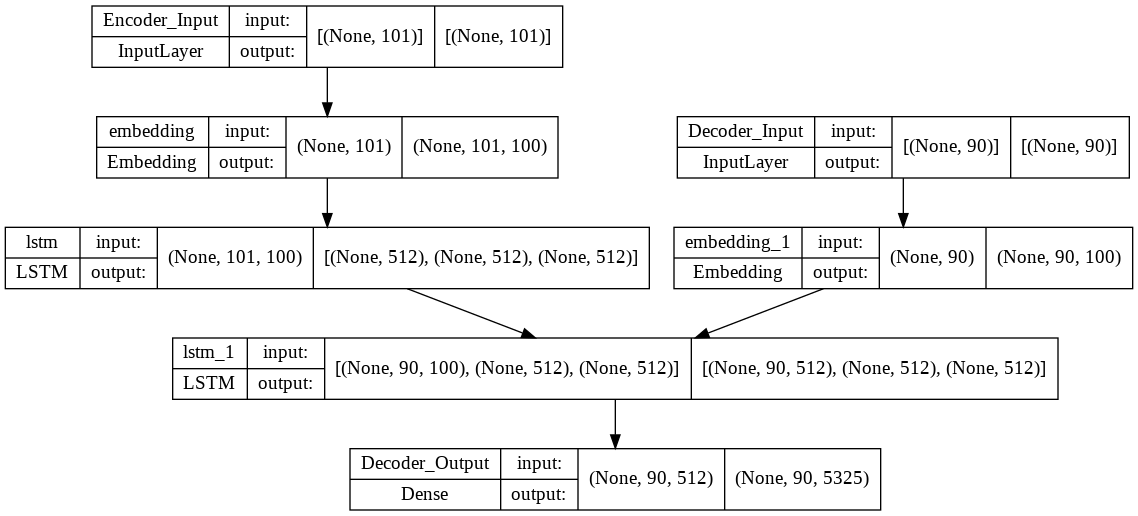

- teacher-forcing model train

Epoch 1/30
42/42 [==============================] - 9s 106ms/step - loss: 0.8603 - accuracy: 0.9280 - val_loss: 0.6490 - val_accuracy: 0.9197
Epoch 2/30
42/42 [==============================] - 3s 84ms/step - loss: 0.5297 - accuracy: 0.9352 - val_loss: 0.6645 - val_accuracy: 0.9230
Epoch 3/30
42/42 [==============================] - 3s 83ms/step - loss: 0.3177 - accuracy: 0.9557 - val_loss: 0.7083 - val_accuracy: 0.9211
Epoch 4/30
42/42 [==============================] - 4s 92ms/step - loss: 0.3012 - accuracy: 0.9585 - val_loss: 0.6443 - val_accuracy: 0.9279
Epoch 5/30
42/42 [==============================] - 4s 83ms/step - loss: 0.2841 - accuracy: 0.9611 - val_loss: 0.6759 - val_accuracy: 0.9285
Epoch 6/30
42/42 [==============================] - 3s 83ms/step - loss: 0.2690 - accuracy: 0.9622 - val_loss: 0.6866 - val_accuracy: 0.9302
Epoch 7/30
42/42 [==============================] - 4s 85ms/step - loss: 0.2600 - accuracy: 0.9623 - val_loss: 0.6557 - val_accuracy: 0.9314
Epoch 8/30
4

- accuracy, loss 시각화

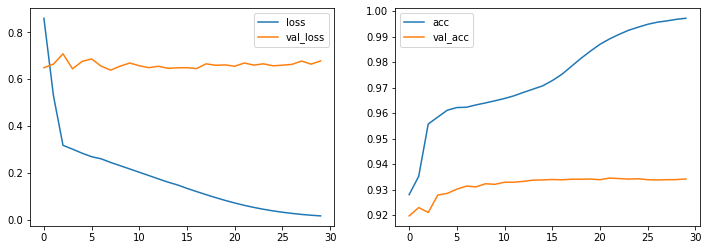

In [ ]:
# plot some data

# accuracies


- save model

## Make Predictions - Inference phase

- prediction 을 위한 별도의 decoder model 작성  

- 별로 training 없이 앞에서 train 된 weights 를 모두 재사용 한다.

- decoder 는 encoder 와 분리되어 구성

In [ ]:
# Decoder for inference


# output, hidden states 를 저장


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Decoder_input (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        multiple             532500      ['Decoder_input[0][0]']          
                                                                                                  
 Decoder_hidden_h (InputLayer)  [(None, 512)]        0           []                               
                                                                                                  
 Decoder_hidden_c (InputLayer)  [(None, 512)]        0           []                               
                                                                                            

- inference 용 decoder model 시각화

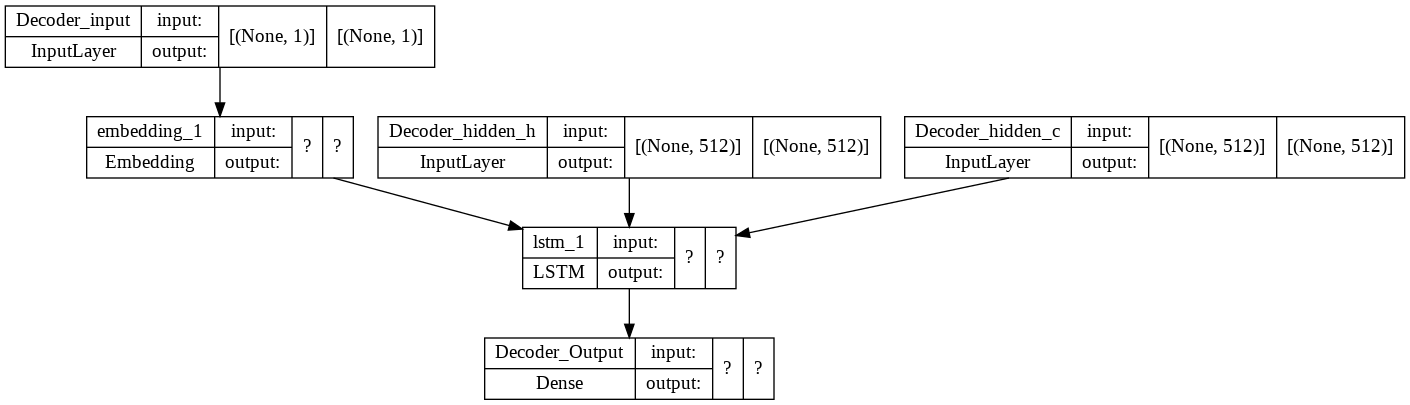

예측하는 동안 index를 단어를 되돌리기 위한 reverse word2idx dictionary 작성

### Translation Inference

In [ ]:
def decode_sequence(input_seq):
   # encoder model을 이용하여 input을 state vector로 encoding


   # Generate empty target sequence of length 1.


   # target sequence 의 첫번째 character 를 start character (<sos>) 로 설정


   # <eos> token이 decode 에서 생성되면 loop 에서 break


   # 번역문 생성
    output_sentence = []
    for _ in range(max_len_kor):


       # argmax 로 가장 확률 높은 단어 선택 --> greedy selection


        if eos == idx:  # <EOS> token
            break

        if idx > 0:  # idx 0 은 zero padding 된 sequence 이므로 ''


        # 생성된 word 를 decoder 의 다음 input 으로 사용


       # Update states


    return ' '.join(output_sentence)

for _ in range(5):


-
Input: Do you two want to be alone?
Translation: 너희 둘은 혼자가 되고싶어?
-
Input: That's my cat.
Translation: 저거 내 고양이야.
-
Input: Tom ran after the dog.
Translation: 톰은 개를 쫓아갔어.
-
Input: I need to finish it.
Translation: 나는 그것을 끝내야 해.
-
Input: Tom is very mature for his age.
Translation: 톰은 나이에 비해 매우 매우 커.


### 임의의 영어 입력을 처리하는 영한 번역 함수

In [ ]:
def Eng_Kor_translation(txt):


In [ ]:
test_text = [
       "Your lips are red.",
       "French is interesting.",
       "I like you.",
       "Let's go to home."
]
for text in test_text:
    translation = Eng_Kor_translation(text)
    print('----')
    print('Input:', text)
    print('Translation:', translation)

----
Input: Your lips are red.
Translation: 네 입술 빨개.
----
Input: French is interesting.
Translation: 프랑스어는 흥미로워.
----
Input: I like you.
Translation: 너 널 좋아해.
----
Input: Let's go to home.
Translation: 나는 좀 가고 마.
